In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc

# setting the info i get from scanpy package
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
sc.logging.print_versions()

scanpy==1.3.7 anndata==0.6.17 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
#Making a output file location
import os
os.getcwd()

'/home/shaggydog/Desktop/JuPytR'

In [4]:
results_file = '/home/gunnar/Desktop/Results/test_output.h5ad'

In [5]:
sc.settings.set_figure_params(dpi=60)

In [6]:
sc.read

<function scanpy.readwrite.read(filename, backed=False, sheet=None, ext=None, delimiter=None, first_column_names=False, backup_url=None, cache=False, **kwargs)>

In [ ]:
sc.rea

In [7]:
# reading in data
# jupyter will create a cache file
adata = sc.read_10x_mtx("/home/shaggydog/Desktop/For_lab_meeting/Results/Ribo_test",var_names='gene_symbols', cache=True)

... writing an h5ad cache file to speedup reading next time


In [8]:
#Note: In notebooks and jupyter lab, you can see the documentation for a python function 
# by hitting SHIFT + TAB. Hit it twice to expand the view.
adata.var_names_make_unique()

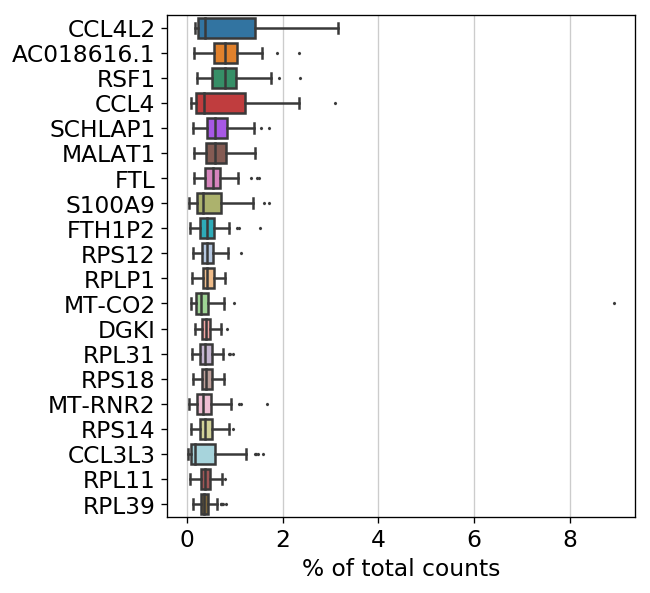

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [10]:
# basic filtering 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 6806 genes that are detected in less than 3 cells


In [11]:
# if you ever have high mito-gene concentration then it possibly is indicative of 
# poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of 
# loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria 
# are larger than individual transcript molecules and less likely to escape through 
# tears in the cell membrane.
# Plot some information about mitochondrial genes, important for quality control. 
# Note that you can also retrieve mitochondrial genes using 

# sc.queries.mitochondrial_genes('www.ensembl.org', 'hsapiens')


In [12]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

mito_genes

In [14]:
np.sum(mito_genes)

26

In [15]:
adata.obs.head()

n_genes  percent_mito  n_counts
0                                            
p6_F2_Unstim     3902      0.022152   15574.0
p6_E4_Unstim     2447      0.015907    6915.0
p6_C6_Unstim     2995      0.011788    9416.0
p6_C10_LPS       3155      0.019154    9972.0
p6_C7_LPS        2268      0.012509    7275.0

In [16]:
adata

AnnData object with n_obs × n_vars = 90 × 14660 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [17]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], 
             jitter=0.4, multi_panel=True)

In [19]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts.
sc.settings.set_figure_params(dpi=100)
sc.pl.scatter(adata, x='n_counts', y='percent_mito',size=20)
sc.pl.scatter(adata, x='n_counts', y='n_genes',size=50, color='percent_mito')

In [16]:
adata

AnnData object with n_obs × n_vars = 90 × 14660 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [21]:
import matplotlib.pyplot as plt

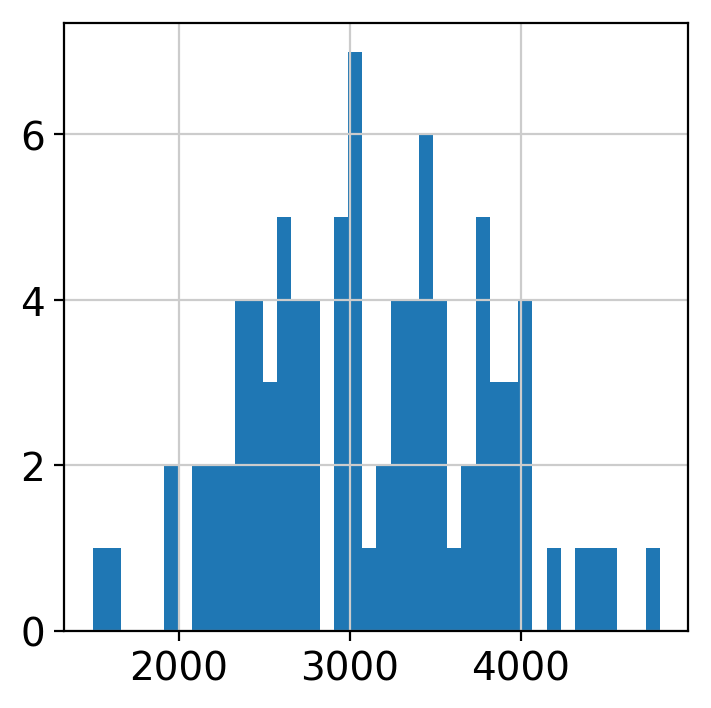

In [24]:
_ = plt.hist(np.sum(adata.X > 0, axis = 1), bins=40)

In [25]:
# Actually do the filtering.
adata = adata[adata.obs['n_genes'] < 4400, :]
adata = adata[adata.obs['n_genes'] > 2200, :]
adata = adata[adata.obs['percent_mito'] < 0.08, :]

In [26]:
adata

View of AnnData object with n_obs × n_vars = 80 × 14660 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [27]:
# Per-cell normalize (library-size correct) the data matrix X, so that counts become comparable among cells.
# Logarithmize the data.
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

In [28]:
# Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use 
# in differential testing and visualizations of gene expression. This simply freezes the state of 
# the AnnData object. While many people consider the normalized data matrix as the "relevant data" 
# for visualization and differential testing, some would prefer to store the unnormalized data.
adata.raw = adata

In [29]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', boolean vector (adata.var)
    'dispersions', boolean vector (adata.var)
    'dispersions_norm', boolean vector (adata.var)


In [30]:
adata.var.head()

gene_ids  n_cells  highly_variable     means  dispersions  \
DPM1      ENSG00000000419       12             True  0.360912     1.724232   
SCYL3     ENSG00000000457       53            False  0.667692     0.060440   
C1orf112  ENSG00000000460        7            False  0.051707    -0.402570   
FGR       ENSG00000000938       16             True  0.332512     1.497319   
GCLC      ENSG00000001084       11            False  0.137871     0.552158   

          dispersions_norm  
DPM1              1.129753  
SCYL3            -1.063677  
C1orf112         -1.257761  
FGR               0.823472  
GCLC              0.332598

In [ ]:
#sc.pp.highly_variable_genes(adata, n_top_genes=4000)

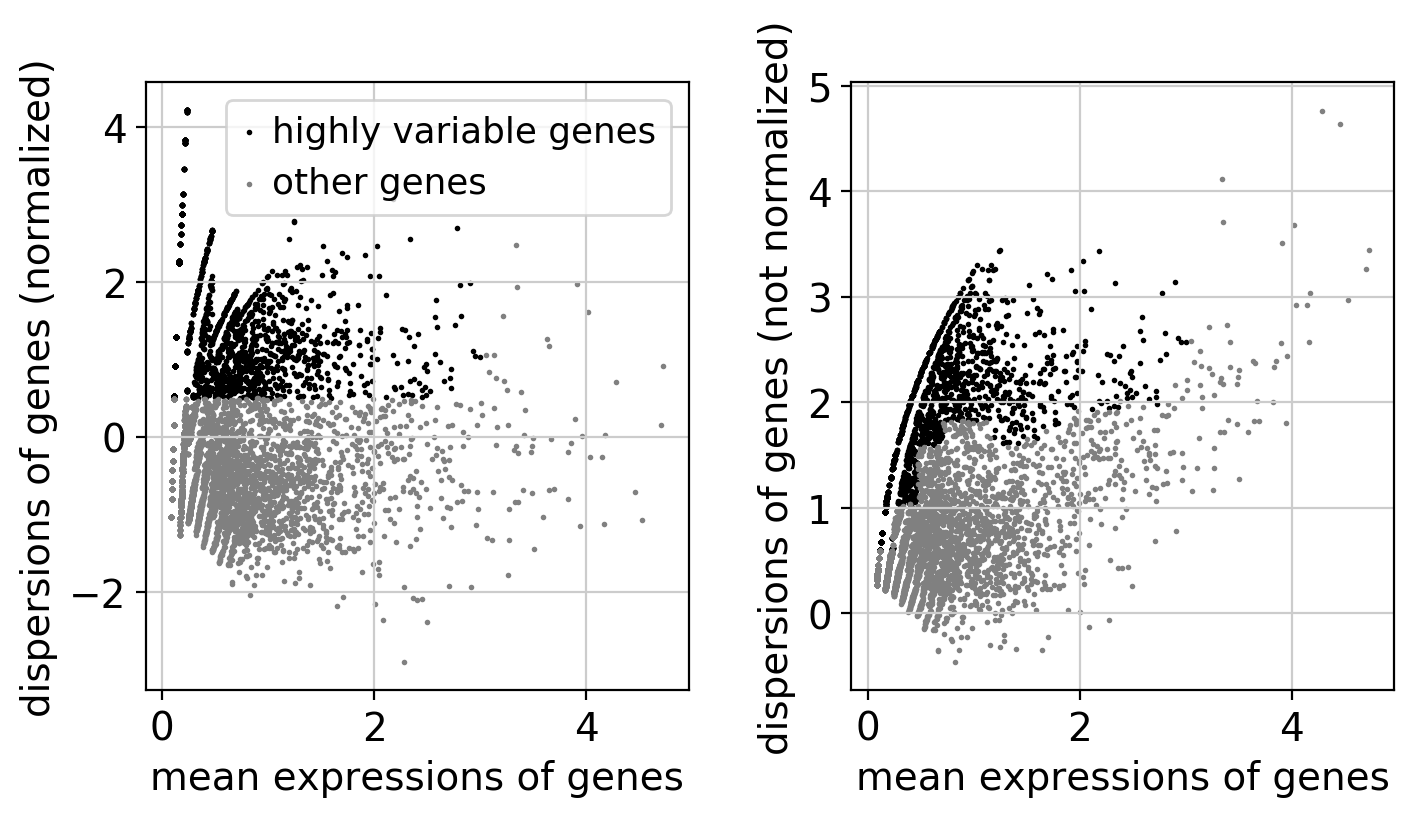

In [21]:
sc.pl.highly_variable_genes(adata)

In [22]:
# Actually do the filtering.
#adata = adata[:, adata.var['highly_variable']]
#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:07.58)


In [32]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)
#Save the result.
#adata.write(results_file)

In [33]:
adata

AnnData object with n_obs × n_vars = 80 × 14660 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [34]:
# Compute PCA and make a scatter plot.
sc.tl.pca(adata,n_comps=10 , svd_solver='auto')

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


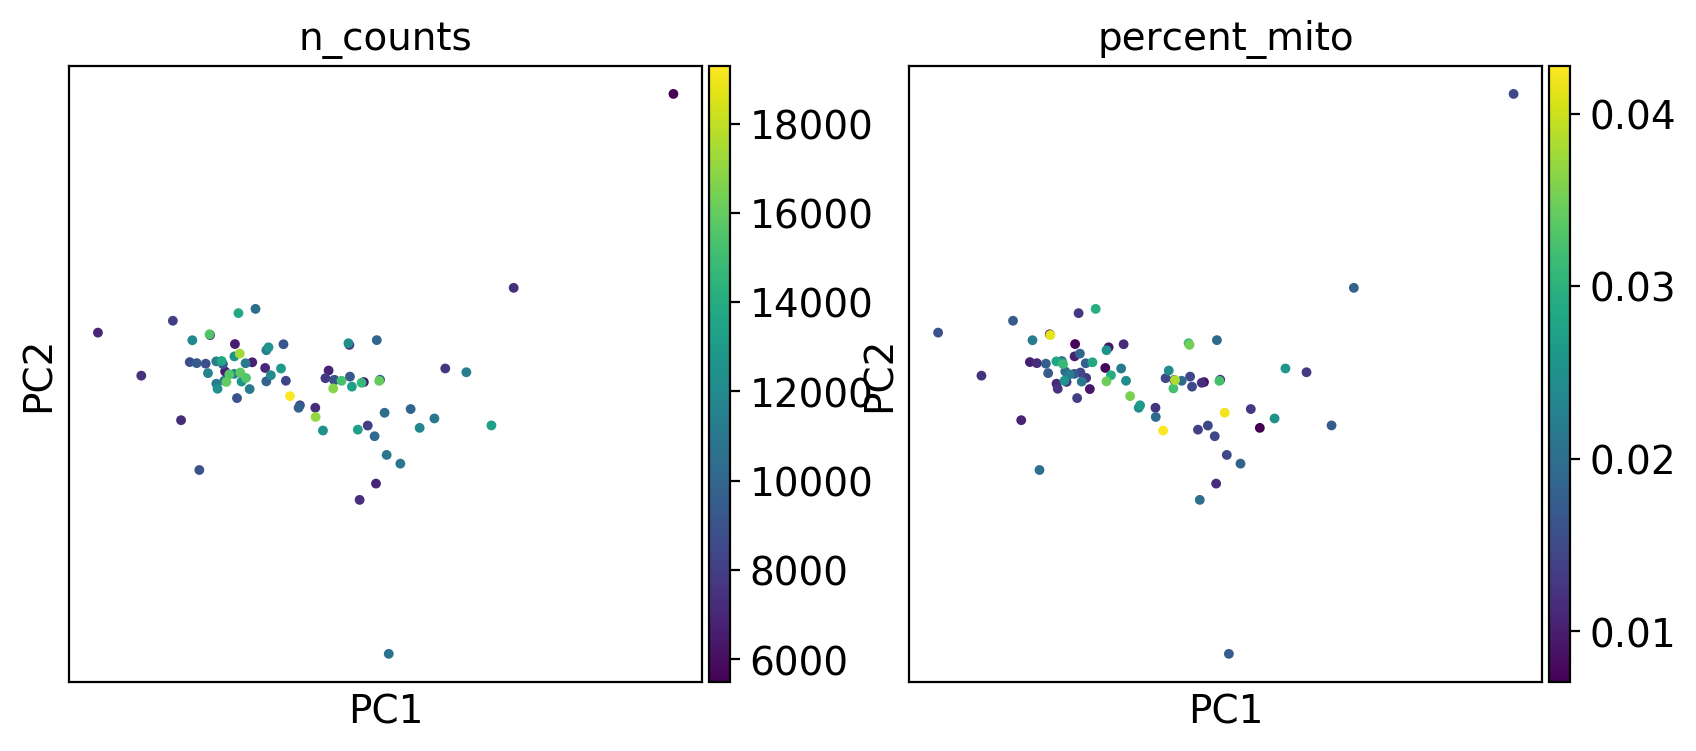

In [39]:
sc.pl.pca(adata, color=['n_counts', 'percent_mito'], size=50)
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often, a rough estimate of the number of PCs 
# does fine. Seurat provides many more functions, here.

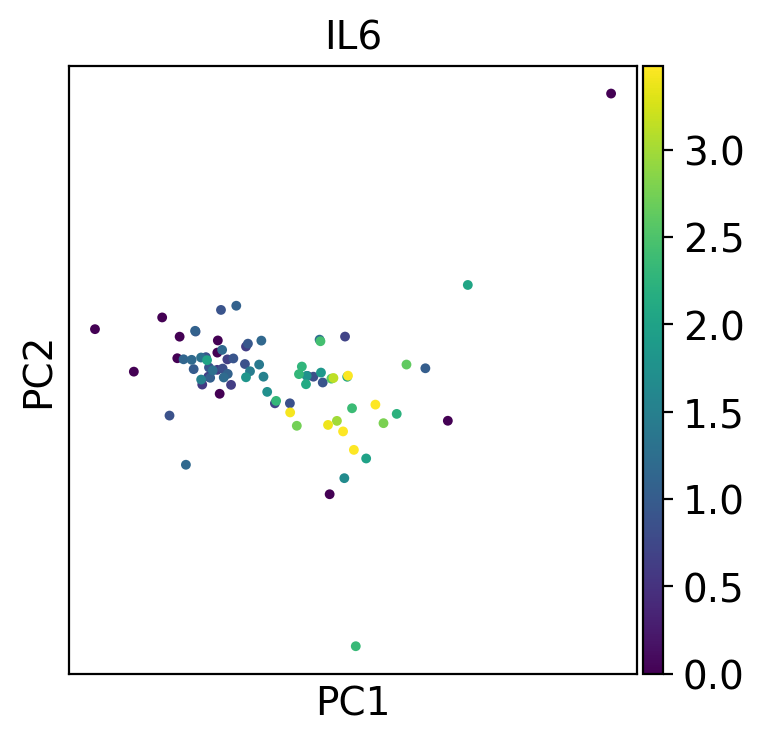

In [41]:
sc.pl.pca(adata, color="IL6", size=50)


SyntaxError: invalid syntax (<ipython-input-37-95eabc8c742d>, line 1)

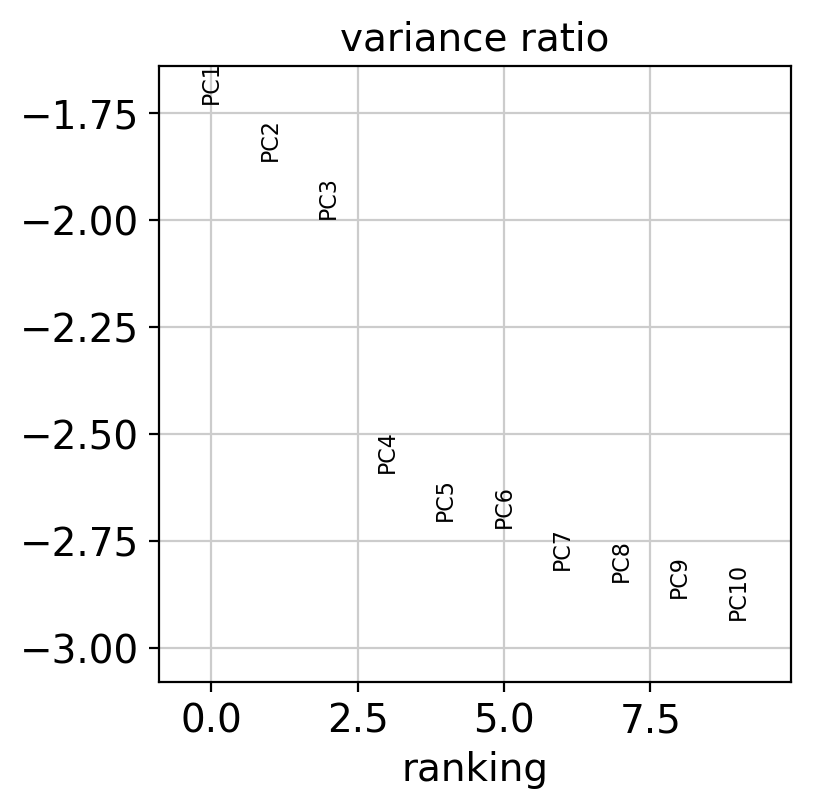

In [27]:
sc.pl.pca_variance_ratio(adata, log=True)

In [28]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 15 × 2422 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [29]:
# Computing the neighborhood graph
adata = sc.read(results_file)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
# We now advertise visualizing the data using UMAP, see below. In particular, 
# if you have large data, this will give you a notable speedup. Also, it is 
# potentially more faithful to global topology: trajectories are better preserved.

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:03.10) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [30]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:01.01) --> added
    'X_umap', UMAP coordinates (adata.obsm)


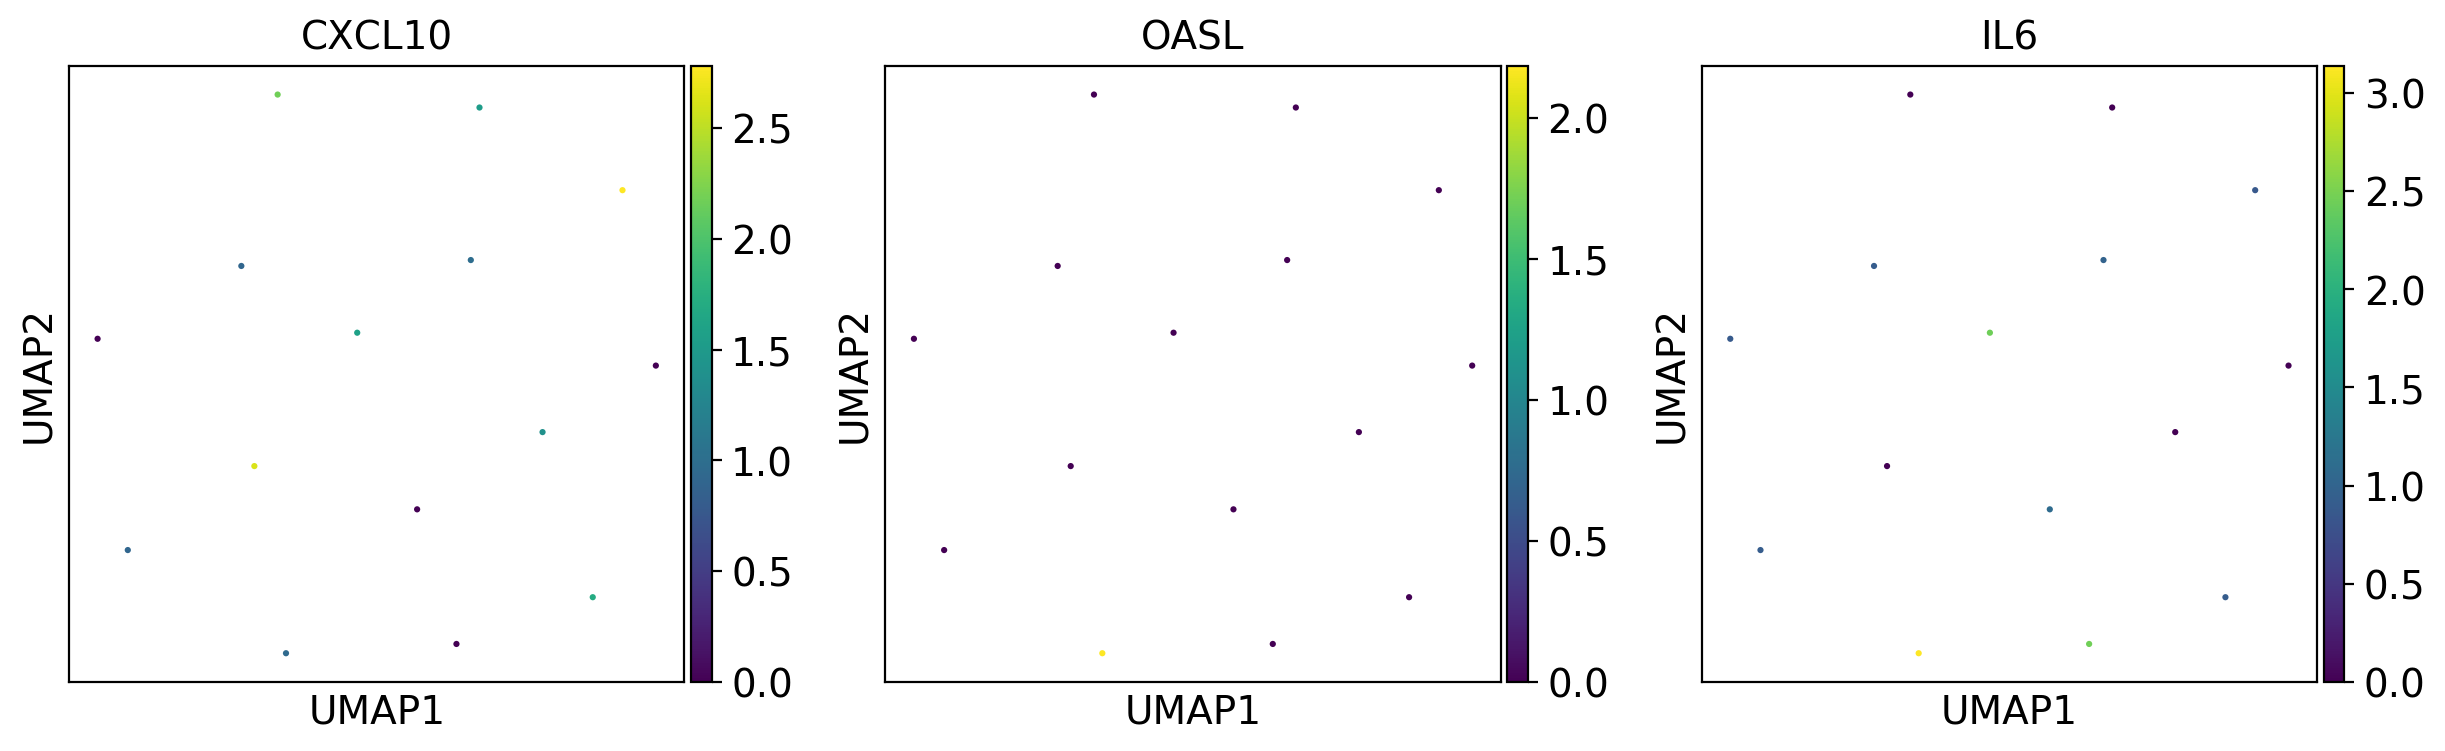

In [31]:
sc.pl.umap(adata, color=['CXCL10', 'OASL', 'IL6'],size=20)

In [32]:
# Clustering the graph
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 2 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [34]:
# Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.
sc.pl.umap(adata, color=['louvain', 'OASL', 'TNF'],size=20)
adata.write(results_file)

In [ ]:
# Finding marker genes